In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

In [6]:
from katacv.utils.related_pkgs.jax_flax_optax_orbax import *
from katacv.ocr.parser import get_args_and_writer
from katacv.ocr.cnn_model import get_ocr_cnn_state

args = get_args_and_writer(no_writer=True, input_args="")
state = get_ocr_cnn_state(args)
weights = ocp.PyTreeCheckpointer().restore("/home/wty/Coding/models/OCR-CNN/OCR-CNN-0002-lite")
print(weights.keys())
# weights = ocp.PyTreeCheckpointer().restore("/home/yy/Coding/models/YOLOv1/YOLOv1-0080-lite")
state = state.replace(params=weights['params'], batch_stats=weights['batch_stats'])
# state = state.replace(params=weights['params'], params_darknet=None, batch_stats=weights['batch_stats'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


dict_keys(['batch_stats', 'opt_state', 'params', 'step'])


In [37]:
from katacv.ocr.ocr_predict import predict, apply_mask
import time
start_time = time.time()
print("XLA compile...")
input_shape = (1, 32, 100, 1)
def predict_result(x):
    pred_idx, mask = predict(state, x)
    y_pred = apply_mask(pred_idx, mask, args.max_label_length)
    pred_seq = []
    for i in range(y_pred.shape[0]):
        seq = []
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] == 0: break
            seq.append(chr(args.idx2ch[y_pred[i,j]]))
        pred_seq.append("".join(seq))
    return pred_seq
predict_result(jnp.empty(input_shape, dtype=jnp.uint8))
print(f"Compile complete! Use time: {time.time() - start_time:.2f} s")

XLA compile...
Compile complete! Use time: 0.02 s


(1, 32, 100, 1)
['pontifically']


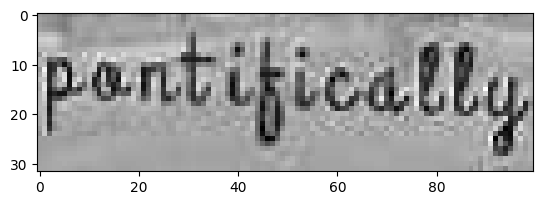

In [38]:
from PIL import Image
x = jnp.array(Image.open(r"/home/wty/Coding/datasets/mjsynth/1/1/1_pontifically_58805.jpg").convert("L").resize((100,32)))[None, ..., None]
import matplotlib.pyplot as plt
plt.imshow(x[0], cmap='gray')
print(x.shape)
print(predict_result(x))

In [46]:
import io, time
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

upload_button = widgets.FileUpload(description="上传图片")
aux_output = widgets.Text("模型/识别用时：")

# 显示图片和调整亮度、对比度的函数
def show_image(upload):
    if upload:
        uploaded_file = upload[0]
        origin_image = Image.open(io.BytesIO(uploaded_file['content'])).convert('L')
        resize_image = origin_image.resize((100,32))
        x = jnp.array(resize_image)[None,...,None].astype('uint8')
        start_time = time.time()
        pred_result = predict_result(x)[0]
        print("Predict result:", pred_result)
        aux_output.value = f"模型用时：{time.time() - start_time:.4f} s"
        
        fig, ax = plt.subplots(figsize=(8,3))
        ax.imshow(origin_image, cmap='gray')
        plt.show()

interactive_output = widgets.interactive_output(
    show_image,
    {
        "upload": upload_button,
    }
)

display(widgets.HBox([upload_button, aux_output]), interactive_output)


Output()